# 8.2 Deep Dream

- try to maximize the activation of entire layers (mixing together visualizations of large numbers of features at onec)
- start not from blank, slightly noisy input, but rather from an existing imgae - thus the resulting effects latch on to preexisting visual patterns, distorting elements of the image in a somewhat artistic fashion.
- The input images are processed at different scales (called octaves), which improves the quality of the visualizations.

In [17]:
# 8.8 Loding the pretrained Inception V3 model

from keras.applications import inception_v3
from keras import backend as K
import scipy
from keras.preprocessing import image


In [18]:

base_img_path = 'east.jpg'

In [19]:
# 8.9 Setting up the DeepDream configuration

layer_contributions = {
    'mixed2' : 0.2,
    'mixed3' : 3.,
    'mixed4' : 2.,
    'mixed5' : 1.5,
} # how much layer's activation contributes to the loss you'll seek to maximize 
# check your all layer names using model.summary()

In [24]:
# fff
def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1] 
    return loss_value, grad_values

def gradient_ascent(x,iterations, step, max_loss = None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss :
            break
        print('...Loss value at', i , ':', loss_value)
        x += step * grad_values
        
    return x

def resize_img(img, size):
    img = np.copy(img)
    factors = (1, float(size[0])/img.shape[1],float(size[1])/img.shape[2],1)
    return scipy.ndimage.zoom(img,factors,order=1) # scipy.ndimage.zoom more+

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname,pil_img)
    
def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis =0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3,x.shape[2], x.shape[3]))
        x = x.transpose((1,2,0))
    else :
        x = x.reshape((x.shape[1],x.shape[2],3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x,0,255).astype('uint8')
    return x

In [21]:

K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights = 'imagenet',include_top=False)

# 8.10 Defining the loss to be maximized

layer_dict = dict([layer.name, layer] for layer in model.layers)

loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation),'float32')) # SCALING IMPORTANT
    loss += coeff * K.sum(K.square(activation[:,2:-2,2:-2,:])) / scaling # avoid border 
    
    # 8.11 Gradient-ascent process

dream = model.input

grads = K.gradients(loss,dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)),1e-7) # Normalize the gradients
outputs = [loss,grads]
fetch_loss_and_grads = K.function([dream],outputs)


In [22]:
# 8.12 Running gradient ascent over different successive scales

import numpy as np

step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 10.

img = preprocess_image(base_img_path) # (1, 440, 720, 3)
original_shape = img.shape[1:3] # (440, 720)
successive_shapes = [original_shape]

for i in range(1, num_octave):
    shape = tuple([int(dim/(octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
    
successive_shapes

[(1698, 1200), (1212, 857), (866, 612)]

In [25]:
original_img = np.copy(img)
shrunk_original_img = resize_img(img,successive_shapes[0])

for shape in successive_shapes:
    print('Processing img shape', shape)
    img = resize_img(img,shape)
    img = gradient_ascent(img, iterations=iterations,step=step,max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img,shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img += lost_detail
    shrunk_original_img = resize_img(original_img,shape)
    save_img(img, fname='dream_at_scale_'+str(shape)+'.png')
save_img(img, fname = 'final_dream22.png')

Processing img shape (1698, 1200)


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Processing img shape (1212, 857)


C:\Users\user\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


...Loss value at 0 : 3.212336
...Loss value at 1 : 4.9322968
...Loss value at 2 : 6.2637234
...Loss value at 3 : 7.3483605
...Loss value at 4 : 8.347355
...Loss value at 5 : 9.266453
Processing img shape (866, 612)
...Loss value at 0 : 2.6361585
...Loss value at 1 : 4.1000977
...Loss value at 2 : 5.322937
...Loss value at 3 : 6.331691
...Loss value at 4 : 7.260509
...Loss value at 5 : 8.114724
...Loss value at 6 : 8.904709
...Loss value at 7 : 9.644193


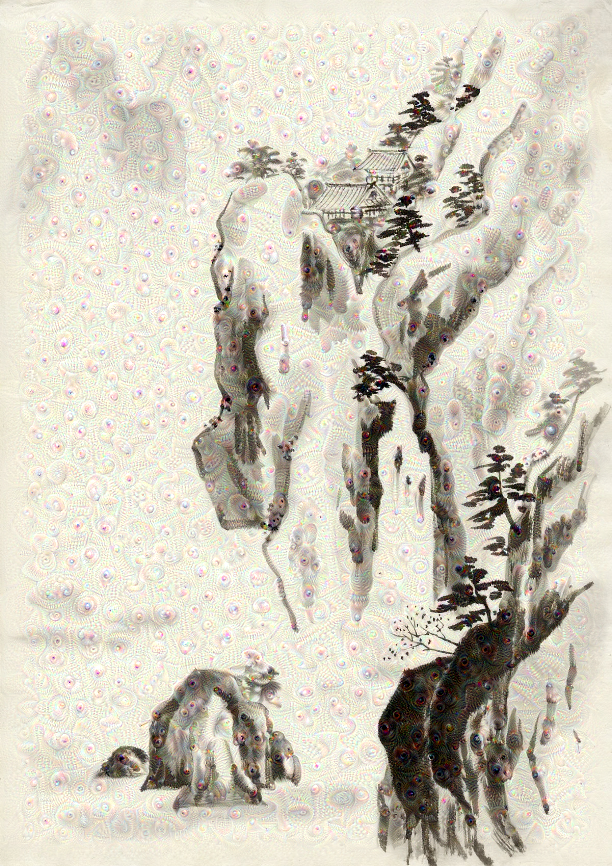

In [26]:
from IPython.display import Image
Image('final_dream22.png')

In [ ]:
# ted talk : https://www.ted.com/talks/blaise_aguera_y_arcas_how_computers_are_learning_to_be_creative?language=en#t-898371


In [10]:
img.shape

(1, 1698, 1200, 3)

In [11]:
successive_shapes =successive_shapes[::-1] # reorder, Reverse
successive_shapes 

[(866, 612), (1212, 857), (1698, 1200)]

In [39]:
test_img = np.copy(img)
test_img = resize_img(test_img,(224,367))
test_img.shape

C:\Users\user\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(1, 224, 367, 3)